<a href="https://colab.research.google.com/github/Mainakdeb/honeywell_hackathon/blob/main/street-vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [134]:
!git clone https://github.com/Mainakdeb/honeywell_hackathon.git
!mv /content/honeywell_hackathon/* /content/
!rm -r /content/honeywell_hackathon/*
!bash /content/config/download_weights.sh
!pip3 install filterpy pytube sk-video

fatal: destination path 'honeywell_hackathon' already exists and is not an empty directory.
mv: cannot stat '/content/honeywell_hackathon/*': No such file or directory
rm: cannot remove '/content/honeywell_hackathon/*': No such file or directory
--2021-02-25 09:35:12--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights.1’

yolov3.weights.1    100%[===================>] 236.52M   101MB/s    in 2.4s    

2021-02-25 09:35:14 (101 MB/s) - ‘yolov3.weights.1’ saved [248007048/248007048]



In [334]:
from models import *
from utils import *
from sort import *
from IPython.display import HTML
from base64 import b64encode
import os, sys, time, datetime, random
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
import skvideo.io  
from pytube import YouTube
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import cv2
from IPython.display import clear_output
import pandas as pd
from scipy.signal import lfilter
from tqdm.notebook import tnrange, tqdm

In [468]:
class_df=pd.read_csv("/content/config/coco.names", header=None)
class_list=class_df[0].to_list()
#len(class_list)
print(class_list[0:10])

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light']


In [470]:
def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms = transforms.Compose([ transforms.Resize((imh, imw)),
         transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)),
                        (128,128,128)),
         transforms.ToTensor(),
         ])
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 80, conf_thres, nms_thres)
    return detections[0]

In [538]:
def download_from_yt(video_link):
    videopath=YouTube(video_link).streams.first().download("yt_downloads/")
    return(videopath)
def detector(input_video_path, num_frames, save_video, save_video_path, df):
  cmap = plt.get_cmap('tab20b')
  colors = [cmap(i)[:3] for i in np.linspace(0, 1, 20)]
  size = 720*16//9, 720
  duration = 2
  fps = 25

  # initialize Sort object and video capture
  vid = cv2.VideoCapture(input_video_path)
  mot_tracker = Sort() 
  frame_arr=[]
  #while(True):
  
  for ii in tnrange(num_frames):
      ret, frame = vid.read()
      frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      pilimg = Image.fromarray(frame)
      detections = detect_image(pilimg)
      #print(detections)##
      img = np.array(pilimg)
      pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
      pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
      unpad_h = img_size - pad_y
      unpad_w = img_size - pad_x
      unique_obj_ids=[]
      unique_obj_labels=[]
      if detections is not None:
          tracked_objects = mot_tracker.update(detections.cpu())
          #rint(tracked_objects)
          unique_labels = detections[:, -1].cpu().unique()
          #print(unique_labels)##
          n_cls_preds = len(unique_labels)
          for x1, y1, x2, y2, obj_id, cls_pred in tracked_objects:
              box_h = int(((y2 - y1) / unpad_h) * img.shape[0])
              box_w = int(((x2 - x1) / unpad_w) * img.shape[1])
              y1 = int(((y1 - pad_y // 2) / unpad_h) * img.shape[0])
              x1 = int(((x1 - pad_x // 2) / unpad_w) * img.shape[1])

              color = colors[int(obj_id) % len(colors)]
              color = [i * 255 for i in color]
              cls = classes[int(cls_pred)]
              cv2.rectangle(frame, (x1, y1), (x1+box_w, y1+box_h), color, 4)
              cv2.rectangle(frame, (x1, y1-35), (x1+len(cls)*19+60, y1), color, -1)
              cv2.putText(frame, cls  + str(int(obj_id)), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 3)

              unique_obj_ids.append(obj_id)
              unique_obj_labels.append(cls_pred)

      counts_list=[] #refresh for each frame
      for j in range(0,len(df.columns)):
          counts_list.append(unique_obj_labels.count(j))

      frame_arr.append(frame)
      df.loc[len(df)] = counts_list

  if save_video:
    skvideo.io.vwrite(save_video_path, frame_arr)

  return(save_video_path)
          

In [539]:
def player(vid_path):
  mp4 = open(vid_path,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML("""
  <video width=400 controls>
        <source src="%s" type="video/mp4">
  </video>
  """ % data_url)

In [540]:
# Initialise config paths
config_path='/content/config/yolov3.cfg'
weights_path='/content/yolov3.weights'
class_path='/content/config/coco.names'
img_size=416
conf_thres=0.8
nms_thres=0.4

# Load model and weights
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)
model.cuda()
model.eval()
classes = utils.load_classes(class_path)
Tensor = torch.cuda.FloatTensor

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [541]:
video_link = input('Enter the youtube video link: ')
local_path = download_from_yt(video_link)

# https://www.youtube.com/watch?v=MNn9qKG2UFI&list=PLcQZGj9lFR7y5WikozDSrdk6UCtAnM9mB&index=2&ab_channel=KarolMajek
# https://www.youtube.com/watch?v=GJNjaRJWVP8&ab_channel=CCTVPeople
# https://www.youtube.com/watch?v=jjlBnrzSGjc&ab_channel=Panasonicsecurity

In [ ]:
insight_df = pd.DataFrame([], columns=class_list[0:9])
len(insight_df.columns)

output_vid_path = detector(local_path,
                         num_frames=2000, 
                         save_video=True, 
                         save_video_path="output_1.mp4", 
                         df=insight_df)

player(output_vid_path)

In [641]:
insight_df

,person,bicycle,car,motorbike,aeroplane,bus,train,truck,boat
0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
1995,0,0,13,0,0,1,0,1,0
1996,0,0,13,0,0,1,0,1,0
1997,0,0,13,0,0,1,0,1,0
1998,1,0,14,0,0,1,0,1,0


In [642]:
def count_total_unique_instances(df, class_list):
    tot_counts=[]
    ret_dict={}

    for i in class_list: 
        ret_dict["total unique "+i+"s"]=None

    for c in class_list:
        all_instances=list(insight_df[c])
        count=0
        for i in range(1,len(all_instances)):
            if all_instances[i]>all_instances[i-1]:
                count+=1
        tot_counts.append(count)

    for i in range(len(tot_counts)):
        ret_dict[list(ret_dict.keys())[i]]=tot_counts[i]

    return(ret_dict)

In [646]:
def visualize_classes(df, class_list, denoise=False): 
    n = 20 # the larger n is, the smoother curve will be in case denoise = True
    b = [1.0 / n] * n
    a = 1

    plt.rcParams['figure.figsize'] =10, 5
    
    plt.xlabel("frame number", fontsize = 15)
    plt.ylabel("count", fontsize = 15)

    all_arr=[]
    for c in class_list:
        arr=list(df[c])
        all_arr.append(arr)
        
    for i in range(len(all_arr)):
        if denoise:
            plt.plot(lfilter(b,a,all_arr[i]), label="count - "+class_list[i])
        else:
            plt.plot(all_arr[i], label="count - "+class_list[i])

    plt.grid()
    plt.legend(fontsize = 12)
    plt.show()

def plot_total_instances(df, class_list):
    dict_tots=count_total_unique_instances(insight_df, class_list)

    plt.rcParams['figure.figsize'] =10, 5
    width = 0.50
    labels=list(dict_tots.keys())
    ind = np.arange(len(list(dict_tots.keys())))
    plt.bar(ind, list(dict_tots.values()), width, label="Total unique instances", color='green', alpha=0.5)
    plt.xticks(ind, labels, rotation='vertical', fontsize=10)
    plt.ylabel('Number of unique instances', fontsize=15)
    plt.xlabel("Classes", fontsize=15)
    plt.grid()
    plt.legend(loc='best')
    plt.show()

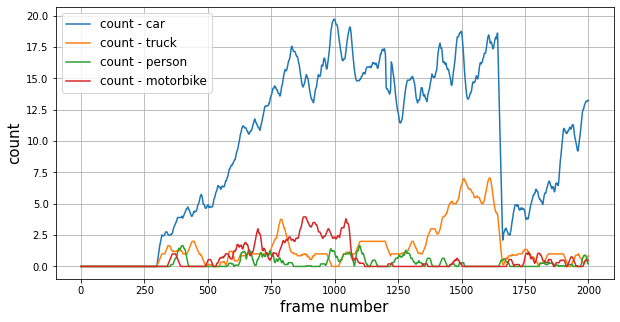

In [647]:
visualize_classes(insight_df, ["car", "truck", "person", "motorbike"], denoise=True)

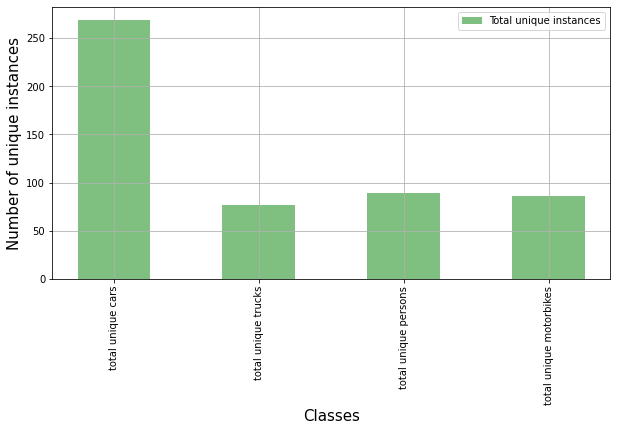

In [648]:
plot_total_instances(insight_df,["car", "truck", "person", "motorbike"])